# ATM Swaption Implied Volatlity Surface PCA Z-score Relative Value

The goal of this is to build a PCA model for the various curves for ATM Swaption Straddles. With that PCA model we are able to calculate the residuals of our fitted PCA model and then use a z-score to find the relative cheapness or richness of specific tenors. We are going to use a 3 Month Lookback.

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Path Management

In [3]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

## Read in Data, seperate out Expiry and Tenor, and slice last 3 months

In [4]:
df_raw = (pd.read_parquet(
    path = os.path.join(data_path, "svols.parquet"),
    engine = "pyarrow").
    drop(columns = ["field"]))

In [5]:
df_expiry_month =  (pd.DataFrame({
    "expiration": ["10", "0A", "0C", "05", "01", "02"],
    "expiry_month": [10 * 12, 1, 3, 5 *12, 12, 2 * 12]}))

In [36]:
df_expiration = (df_raw.assign(
    expiration = lambda x: x.ticker.str.split("USSN").str[1].str.strip().str[0:2]).
    merge(
        df_expiry_month,
        how = "inner",
        on = ["expiration"]).
    drop(columns = ["expiration"]).
    assign(date = lambda x: pd.to_datetime(x.date)))

In [37]:
df_count = (df_expiration.assign(
    letter_count = lambda x: x.ticker.str.len()))

df_lower, df_upper = df_count.query("letter_count == 19"), df_count.query("letter_count == 20")

In [46]:
df_lower_tenor = (df_lower.assign(
    tenor_year = lambda x: x.ticker.str.split(" ").str[0].str[-1].astype(int)).
    drop(columns = ["letter_count"]))

In [47]:
df_upper_tenor = (df_upper.assign(
    tenor_year = lambda x: x.ticker.str.split(" ").str[0].str[-2:].astype(int)).
    drop(columns = "letter_count"))

In [48]:
df_tenor = pd.concat([df_lower_tenor, df_upper_tenor])

In [49]:
max_date = df_tenor.date.max()
cutoff_date = max_date - dt.timedelta(days = 30)

df_window = (df_tenor.query(
    "date >= @cutoff_date"))

## Exploratory Data Analysis

<AxesSubplot:title={'center':'1 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'3 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'12 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'24 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'60 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'120 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

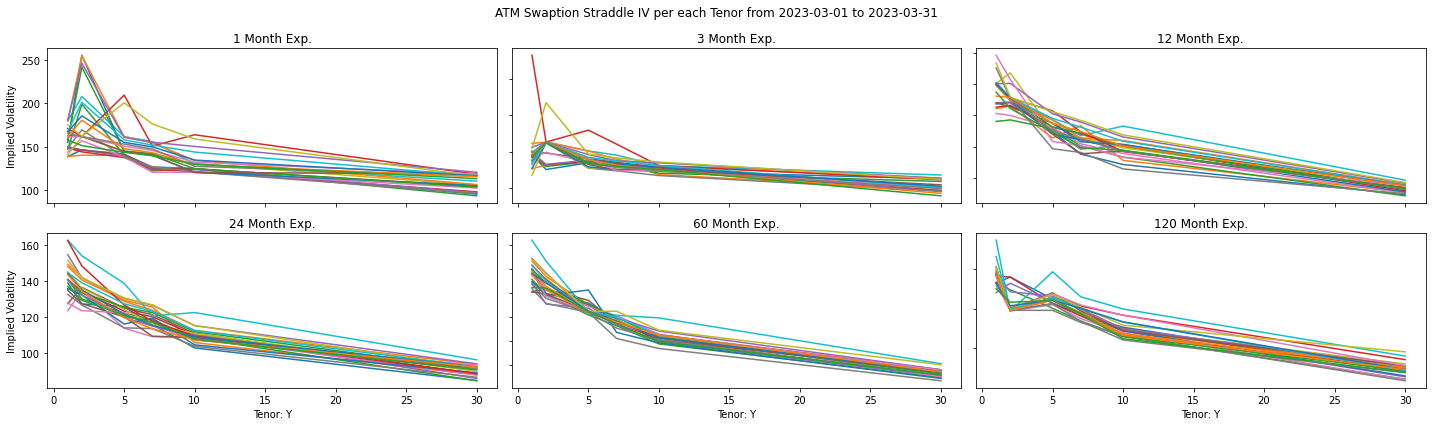

In [50]:
EXPERIES = df_window.expiry_month.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0

for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        display(df_window.query(
            "expiry_month == @expiry").
            drop(columns = ["ticker", "expiry_month"]).
            rename(columns = {"tenor_year": "Tenor: Y"}).
            pivot(index = "Tenor: Y", columns = "date", values = "value").
            plot(
                ax = axes[i,j], legend = False, title = str(expiry) + " Month Exp.",
                sharex = True, ylabel = "Implied Volatility", sharey = True))

        counter += 1

fig.suptitle("ATM Swaption Straddle IV per each Tenor from {} to {}".format(
    df_window.date.min().date(), df_window.date.max().date()))
plt.tight_layout()
plt.show()

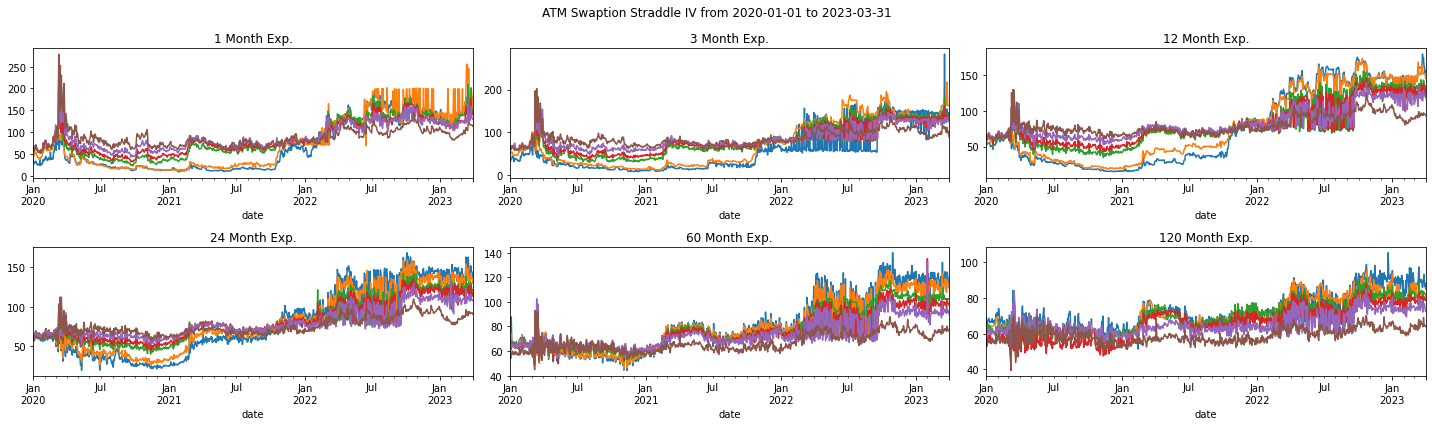

In [52]:
EXPERIES = df_tenor.expiry_month.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0

for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        (df_tenor.query(
            "expiry_month == @expiry").
            drop(columns = ["ticker", "expiry_month"]).
            rename(columns = {"tenor_year": "Tenor: Y"}).
            pivot(index = "date", columns = "Tenor: Y", values = "value").
            plot(
                ax = axes[i,j], title = str(expiry) + " Month Exp.", legend = False))

        counter += 1

fig.suptitle("ATM Swaption Straddle IV from {} to {}".format(
    df_tenor.date.min().date(), df_tenor.date.max().date()))
fig.tight_layout()
plt.show()

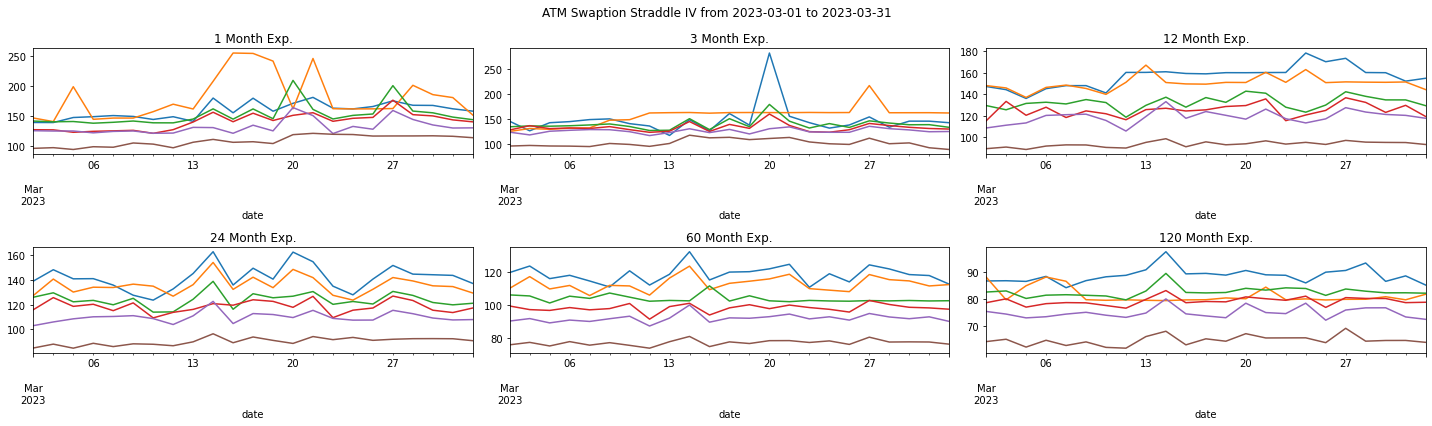

In [54]:
EXPERIES = df_window.expiry_month.drop_duplicates().sort_values().to_list()

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0

for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        (df_window.query(
            "expiry_month == @expiry").
            drop(columns = ["ticker", "expiry_month"]).
            rename(columns = {"tenor_year": "Tenor: Y"}).
            pivot(index = "date", columns = "Tenor: Y", values = "value").
            plot(
                ax = axes[i,j], title = str(expiry) + " Month Exp.", legend = False))

        counter += 1

fig.suptitle("ATM Swaption Straddle IV from {} to {}".format(
    df_window.date.min().date(), df_window.date.max().date()))
fig.tight_layout()
plt.show()